In [1]:
import torch
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scvi
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import poisson_atac as patac
from scipy.sparse import csr_matrix

Global seed set to 0


In [2]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_2022_ATAC.h5ad")

# Embed ATAC

In [3]:
n_peaks_before = adata.shape[1]

In [4]:
sc.pp.filter_genes(adata, min_cells=int(adata.shape[0]*0.01))

In [5]:
print(f"filtered {n_peaks_before - adata.n_vars} peaks.")

filtered 29724 peaks.


In [6]:
adata.layers["ATAC_counts"] = csr_matrix(adata.X.copy())

In [7]:
adata.obs["batch"] = 1

In [8]:
patac.model.PoissonVI.setup_anndata(adata, layer="ATAC_counts", batch_key="batch")

In [9]:
poiss_vi = patac.model.PoissonVI(adata)


In [10]:
poiss_vi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 86/500:  17%|██████████████▉                                                                        | 86/500 [21:47<1:44:52, 15.20s/it, loss=4.23e+04, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 43515.496. Signaling Trainer to stop.


<AxesSubplot:xlabel='epoch', ylabel='kl_global_train'>

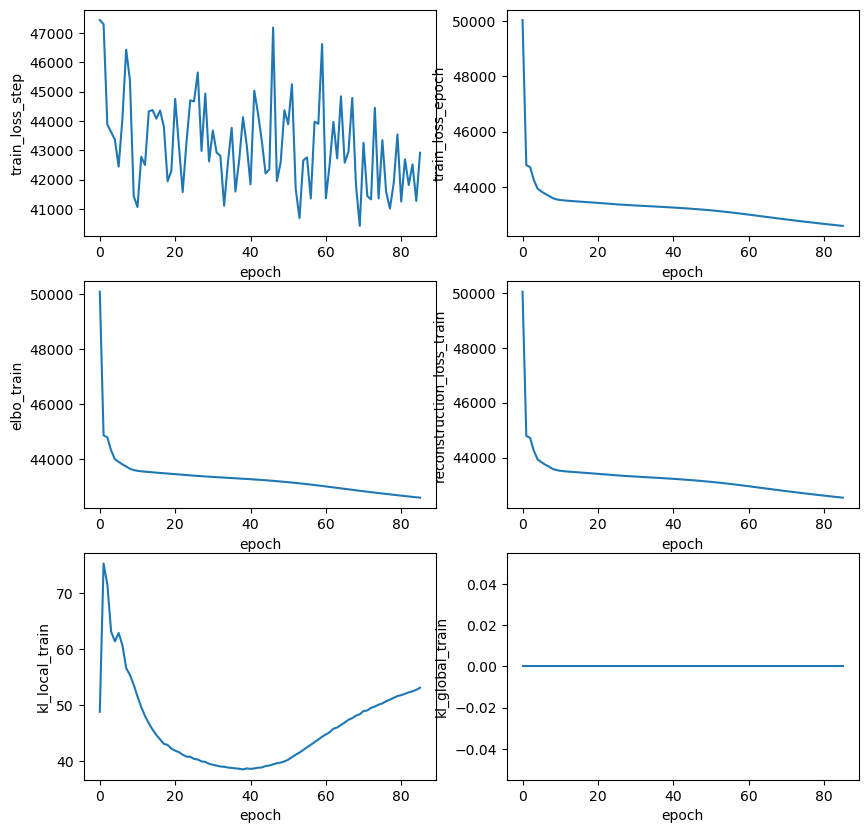

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

sns.lineplot(data=poiss_vi.history['train_loss_step'], x="epoch", y="train_loss_step", ax=axs[0][0])
sns.lineplot(data=poiss_vi.history['train_loss_epoch'], x="epoch", y="train_loss_epoch", ax=axs[0][1])
sns.lineplot(data=poiss_vi.history['elbo_train'], x="epoch", y="elbo_train", ax=axs[1][0])
sns.lineplot(data=poiss_vi.history['reconstruction_loss_train'], x="epoch", y='reconstruction_loss_train', ax=axs[1][1])
sns.lineplot(data=poiss_vi.history['kl_local_train'], x="epoch", y='kl_local_train', ax=axs[2][0])
sns.lineplot(data=poiss_vi.history['kl_global_train'], x="epoch", y='kl_global_train', ax=axs[2][1])

In [12]:
adata.obsm["X_poiss_vi"]=poiss_vi.get_latent_representation()


In [13]:
adata

AnnData object with n_obs × n_vars = 16918 × 198535
    obs: 'old_index', 'celltype', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'log_nCount_ATAC', 'log_nFeature_ATAC', 'sample', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'lsi_full', 'lsi_red', 'lsi_red2', 'X_poiss_vi'
    layers: 'ATAC_counts'

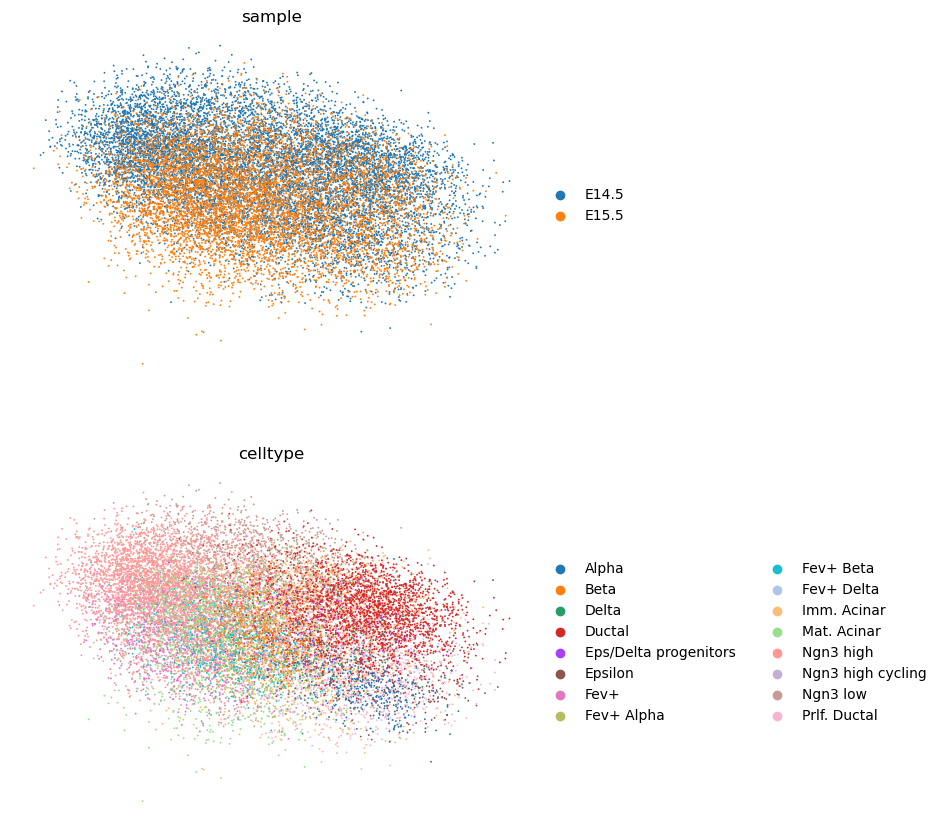

In [14]:
sc.pl.embedding(
    adata,
    basis="X_poiss_vi",
    color=["sample", "celltype"],
    frameon=False,
    ncols=1,
)

In [15]:
adata

AnnData object with n_obs × n_vars = 16918 × 198535
    obs: 'old_index', 'celltype', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'log_nCount_ATAC', 'log_nFeature_ATAC', 'sample', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'sample_colors', 'celltype_colors'
    obsm: 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'lsi_full', 'lsi_red', 'lsi_red2', 'X_poiss_vi'
    layers: 'ATAC_counts'

In [16]:
sc.pp.neighbors(adata, use_rep="X_poiss_vi")
sc.tl.umap(adata)

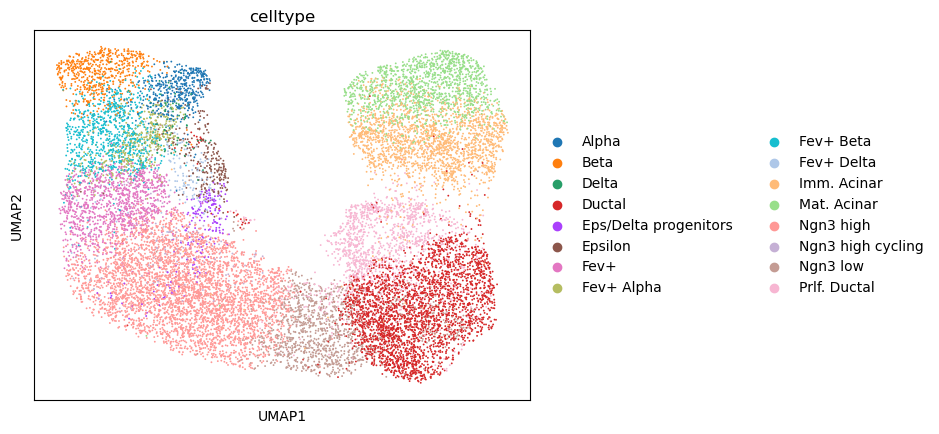

In [17]:
sc.pl.umap(adata, color="celltype")

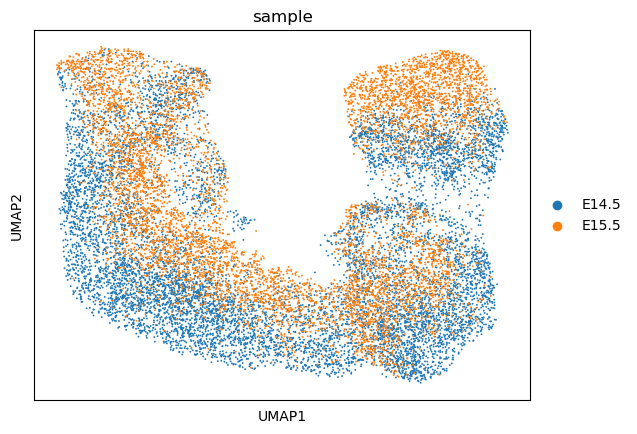

In [18]:
sc.pl.umap(adata, color="sample")

In [19]:
adata.write("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_poissonVI_embedding.h5ad")

In [20]:
poiss_vi.save("/lustre/groups/ml01/workspace/moscot_paper/pancreas/models/peakVI", overwrite=False, save_anndata=True)